<a href="https://colab.research.google.com/github/ejrtks1020/Computer_Vision_Project/blob/main/Fruit_Images_Object_Detection_(Yolo_v5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fruit Images for Object Detection
Containing labelled fruit images to train object detection systems.

https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection

##3 different fruits:
* Apple
* Banana
* Orange


#0. Ultralytics Yolo v5 설치

In [1]:
# Clone and install YOLOv5
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt
%cd ..

Cloning into 'yolov5'...
remote: Enumerating objects: 10797, done.
remote: Total 10797 (delta 0), reused 0 (delta 0), pack-reused 10797
Receiving objects: 100% (10797/10797), 10.90 MiB | 15.18 MiB/s, done.
Resolving deltas: 100% (7460/7460), done.
/content/yolov5
     |████████████████████████████████| 596 kB 12.7 MB/s 
/content


#1. 데이터 다운로드

In [2]:
import os

os.environ['KAGGLE_USERNAME'] = ''
os.environ['KAGGLE_KEY'] = ''

In [3]:
!mkdir fruit_images
%cd fruit_images

/content/fruit_images


In [4]:
!kaggle datasets download -d mbkinaci/fruit-images-for-object-detection

 99% 28.0M/28.4M [00:01<00:00, 14.7MB/s]
100% 28.4M/28.4M [00:01<00:00, 24.2MB/s]


In [ ]:
!unzip '*.zip'

In [6]:
# Ultralytics Yolo images와 labels 디렉토리를 train, val 용으로 생성
!mkdir /content/Fruit;
!mkdir /content/Fruit/images; mkdir /content/Fruit/labels
!mkdir /content/Fruit/images/train; mkdir /content/Fruit/images/val
!mkdir /content/Fruit/labels/train; mkdir /content/Fruit/labels/val

#2. 데이터 셋의 annotation을 Ultralytics Yolo format으로 생성
* annotation용 xml 파일을 txt 파일로 변환
* 하나의 이미지는 하나의 txt 파일로 변환
* 확장자를 제외한 이미지의 파일명과 annotation 파일명이 서로 동일해야 함. 
* 하나의 xml annotation 파일을 Yolo 포맷용 txt 파일로 변환하는 함수 생성
* voc annotation의 좌상단(Top left: x1, y1), 우하단(Bottom right: x2, y2) 좌표를 Bounding Box 중심 좌표(Center_x, Center_y)와 너비(width), 높이(height)로 변경
* 중심 좌표와 너비, 높이는 원본 이미지 레벨로 scale 되어야 함. 모든 값은 0~1 사이 값으로 변환됨. 
* class_id는 여러개의 label들을 0 부터 순차적으로 1씩 증가시켜 id 부여

In [8]:
!cat /content/fruit_images/train_zip/train/apple_1.xml

<annotation>
	<folder>train</folder>
	<filename>apple_1.jpg</filename>
	<path>C:\tensorflow1\models\research\object_detection\images\train\apple_1.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>0</width>
		<height>0</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>8</xmin>
			<ymin>15</ymin>
			<xmax>331</xmax>
			<ymax>349</ymax>
		</bndbox>
	</object>
</annotation>


In [9]:
# Class 명을 부여, Class id는 자동적으로 CLASS_NAMES 개별 원소들을 순차적으로 0부터 부여
CLASS_NAMES = ['apple', 'banana', 'orange']

In [13]:
import glob
import xml.etree.ElementTree as ET
import cv2
xml_file = '/content/fruit_images/train_zip/train/apple_1.xml'
tree = ET.parse(xml_file)
root = tree.getroot()

In [14]:
img_node = root.find('size')

In [15]:
w, h = int(img_node.find('width').text), int(img_node.find('height').text)
if w == '' or h == 0:
  w, h = cv2.imread(xml_file.replace('.xml', '.jpg')).shape[:2]

In [16]:
w, h

(349, 349)

In [17]:
obj = root.find('object')

In [18]:
xmlbox = obj.find('bndbox')
x1 = int(xmlbox.find('xmin').text)
y1 = int(xmlbox.find('ymin').text)
x2 = int(xmlbox.find('xmax').text)
y2 = int(xmlbox.find('ymax').text)

In [19]:
(x1, y1), (x2, y2)

((8, 15), (331, 349))

In [20]:
object_name = obj.find('name').text
object_name

'apple'

In [21]:
center_x = (x1 + x2) / 2
center_y = (y1 + y2) / 2
bbox_width = x2 - x1
bbox_height = y2 - y1
center_x_norm = round(center_x / w, 7)
center_y_norm = round(center_y / h, 7)
bbox_width_norm = round(bbox_width / w, 7)
bbox_height_norm = round(bbox_height / h, 7)

class_id = CLASS_NAMES.index(object_name)

center_x_norm, center_y_norm, bbox_width_norm, bbox_height_norm, class_id

(0.4856734, 0.52149, 0.9255014, 0.9570201, 0)

In [22]:
def xml_to_txt(input_xml_file, output_txt_file):
  # ElementTree로 입력 XML파일 파싱
  tree = ET.parse(input_xml_file)
  root = tree.getroot()
  img_node = root.find('size')
  # 만약 img_node를 찾지 못하면 해당 xml파일을 변환 종료
  if img_node is None:
    return None

  # 원본 이미지의 너비와 높이 추출.
  img_width = int(img_node.find('width').text)
  img_height = int(img_node.find('height').text)

  # 만약 너비와 높이 값이 0이라면 이미지 파일을 읽어서 너비와 높이를 구함
  if img_width == 0 or img_height == 0:
    img_height, img_width = cv2.imread(input_xml_file.replace('.xml', '.jpg')).shape[:2]
  
  # xml 파일내에 있는 모든 object Element를 찾는다.
  with open(output_txt_file, 'w') as output_fpointer:
    for obj in root.findall('object'):
      # bndbox를 찾아서 좌상단(x1, y1), 우하단(x2, y2) 좌표 추출.
      xmlbox = obj.find('bndbox')
      x1 = int(xmlbox.find('xmin').text)
      y1 = int(xmlbox.find('ymin').text)
      x2 = int(xmlbox.find('xmax').text)
      y2 = int(xmlbox.find('ymax').text)

      object_name = obj.find('name').text

      # 만약 좌표중에 0보다 작은 값이 있으면 해당 xml파일 변환 종료
      if (x1 < 0) or (y1 < 0) or (x2 < 0) or (y2 < 0):
        break
      
      # object_name 원본 좌표를 입력하여 Yolo 포맷으로 변환하는 함수 호출
      class_id, cx_norm, cy_norm, bbw_norm, bbh_norm = convert_yolo_coord(object_name, img_width, img_height, x1, y1, x2, y2)

      #변환된 yolo 좌표를 object별로 출력 text 파일에 write
      value_str = ('{0} {1} {2} {3} {4}').format(class_id, cx_norm, cy_norm, bbw_norm, bbh_norm)
      output_fpointer.write(value_str + '\n')

def convert_yolo_coord(object_name, img_width, img_height, x1, y1, x2, y2):
  # class_id는 CLASS_NAMES 리스트에서 index 번호로 추출.
  class_id = CLASS_NAMES.index(object_name)
  # 중심 좌표와 너비, 높이 계산. 
  center_x = (x1 + x2)/2
  center_y = (y1 + y2)/2
  width = x2 - x1
  height = y2 - y1
  # 원본 이미지 기준으로 중심 좌표와 너비 높이를 0-1 사이 값으로 scaling
  center_x_norm = center_x / img_width
  center_y_norm = center_y / img_height
  width_norm = width / img_width
  height_norm = height / img_height

  return class_id, round(center_x_norm, 7), round(center_y_norm, 7), round(width_norm, 7), round(height_norm, 7)


In [24]:
xml_to_txt('/content/fruit_images/train_zip/train/apple_1.xml','/content/Fruit/labels/train/apple_1.txt')

## VOC Format의 여러개 xml 파일들을 Yolo format으로 변환

In [25]:
import shutil

def make_yolo_anno_file(src_dir, target_imgs_dir, target_labels_dir):
  img_path_list = glob.glob(src_dir + '/*.jpg')
  label_path_list = glob.glob(src_dir + '/*.xml')
  
  for img_path in img_path_list:
    shutil.copy(img_path, target_imgs_dir+'/'+img_path.split('/')[-1])
  
  for label_path in label_path_list:
    xml_to_txt(label_path, target_labels_dir + '/' + label_path.split('/')[-1].replace('.xml', '.txt'))

# train용 images와 label annotations 생성
make_yolo_anno_file('/content/fruit_images/train_zip/train', '/content/Fruit/images/train', '/content/Fruit/labels/train')
# val용 images와 label annotations 생성
make_yolo_anno_file('/content/fruit_images/test_zip/test', '/content/Fruit/images/val', '/content/Fruit/labels/val')  

In [49]:
'apple_12.xml'.split('_')[0]

'apple'

# 3. Fruit Image Dataset 학습 수행

In [26]:
!mkdir /content/drive/MyDrive/Fruit_images

In [28]:
!python yolov5/train.py --img 512 --batch 8 --epochs 30 \
--data '/content/Fruit/fruit.yaml' \
--weights yolov5/yolov5s.pt --cache \
--project /content/drive/MyDrive/Fruit_images --name fruit --exist-ok

train: weights=yolov5/yolov5s.pt, cfg=, data=/content/Fruit/fruit.yaml, hyp=yolov5/data/hyps/hyp.scratch.yaml, epochs=30, batch_size=8, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=/content/drive/MyDrive/Fruit_images, name=fruit, exist_ok=True, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-224-g4c40933 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.01

# 4. 이미지 Detection 수행

In [30]:
!mkdir detect_output

In [ ]:
!python yolov5/detect.py --weights /content/drive/MyDrive/Fruit_images/fruit/weights/best.pt \
--conf 0.25 --source /content/Fruit/images/val --project detect_output

In [43]:
# ground truth 이미지와 labels, predicted 이미지 경로 저장
gt_imgs = sorted(glob.glob('/content/Fruit/images/val/*.jpg'))
pred_imgs = sorted(glob.glob('/content/detect_output/exp/*.jpg'))
gt_labels = sorted(glob.glob('/content/Fruit/labels/val/*.txt'))

In [44]:
gt_imgs[:10]

['/content/Fruit/images/val/apple_77.jpg',
 '/content/Fruit/images/val/apple_78.jpg',
 '/content/Fruit/images/val/apple_79.jpg',
 '/content/Fruit/images/val/apple_80.jpg',
 '/content/Fruit/images/val/apple_81.jpg',
 '/content/Fruit/images/val/apple_82.jpg',
 '/content/Fruit/images/val/apple_83.jpg',
 '/content/Fruit/images/val/apple_84.jpg',
 '/content/Fruit/images/val/apple_85.jpg',
 '/content/Fruit/images/val/apple_86.jpg']

In [45]:
gt_labels[:10]

['/content/Fruit/labels/val/apple_77.txt',
 '/content/Fruit/labels/val/apple_78.txt',
 '/content/Fruit/labels/val/apple_79.txt',
 '/content/Fruit/labels/val/apple_80.txt',
 '/content/Fruit/labels/val/apple_81.txt',
 '/content/Fruit/labels/val/apple_82.txt',
 '/content/Fruit/labels/val/apple_83.txt',
 '/content/Fruit/labels/val/apple_84.txt',
 '/content/Fruit/labels/val/apple_85.txt',
 '/content/Fruit/labels/val/apple_86.txt']

In [46]:
pred_imgs[:10]

['/content/detect_output/exp/apple_77.jpg',
 '/content/detect_output/exp/apple_78.jpg',
 '/content/detect_output/exp/apple_79.jpg',
 '/content/detect_output/exp/apple_80.jpg',
 '/content/detect_output/exp/apple_81.jpg',
 '/content/detect_output/exp/apple_82.jpg',
 '/content/detect_output/exp/apple_83.jpg',
 '/content/detect_output/exp/apple_84.jpg',
 '/content/detect_output/exp/apple_85.jpg',
 '/content/detect_output/exp/apple_86.jpg']

In [ ]:
CLASSES

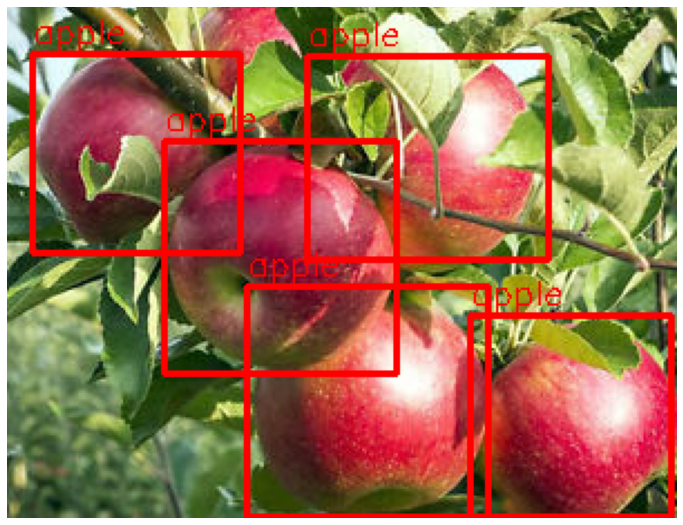

In [66]:
import matplotlib.pyplot as plt
# 이미지 파일과 annotation 파일을 불러와서 시각화
img = cv2.imread(gt_imgs[0])
h, w = img.shape[:2]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
CLASS_NAMES = ['apple', 'banana', 'orange']

COLOR_LIST = [(255, 0, 0),
              (0, 255, 0),
              (0, 0, 255)]

with open(gt_labels[0], 'r') as f:
  for line in f:
    l = list(map(float, line.strip('\n').split(' ')))
    # yolo data format은 bounding box의 중심좌표(l[1], l[2])와 박스의 너비와 높이(l[3], l[4])로 저장되어 있으며 이미지 크기를 기준으로 0 ~ 1사이 값으로 scaling 되어있음
    # 따라서 width와 height를 곱해서 원래값을 구한다.
    center_x, center_y = int(l[1] * w), int(l[2] * h)  
    box_w, box_h = int(l[3] * w), int(l[4] * h)

    # opencv로 bounding box를 그리기 위해 좌상단, 우하단 좌표를 계산
    left = int(center_x - (box_w / 2))
    top = int(center_y - (box_h / 2))
    right = int(left + box_w)
    bottom = int(top + box_h)

    # 레이블(l[0]) 값에따라 박스와 caption의 색을 지정
    class_id = int(l[0])
    color = COLOR_LIST[class_id]
    caption = CLASS_NAMES[class_id]

    cv2.rectangle(img, (left,top), (right, bottom), color = color, thickness = 2)
    cv2.putText(img, caption, (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.axis('off')
plt.show()

In [54]:
# 이미지에 바운딩 박스를 추가하는 함수
def draw_box(img, annot):
  h, w = img.shape[:2]
  with open(annot, 'r') as f:
    for line in f:
      l = list(map(float, line.strip('\n').split(' ')))
      center_x, center_y = int(l[1] * w), int(l[2] * h)
      box_w, box_h = int(l[3] * w), int(l[4] * h)

      left = int(center_x - (box_w / 2))
      top = int(center_y - (box_h / 2))
      right = int(left + box_w)
      bottom = int(top + box_h)

      class_id = int(l[0])
      color = COLOR_LIST[class_id]
      caption = CLASS_NAMES[class_id]

      cv2.rectangle(img, (left,top), (right, bottom), color = color, thickness = 2)
      cv2.putText(img, caption, (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

  return img

# 비교 및 시각화

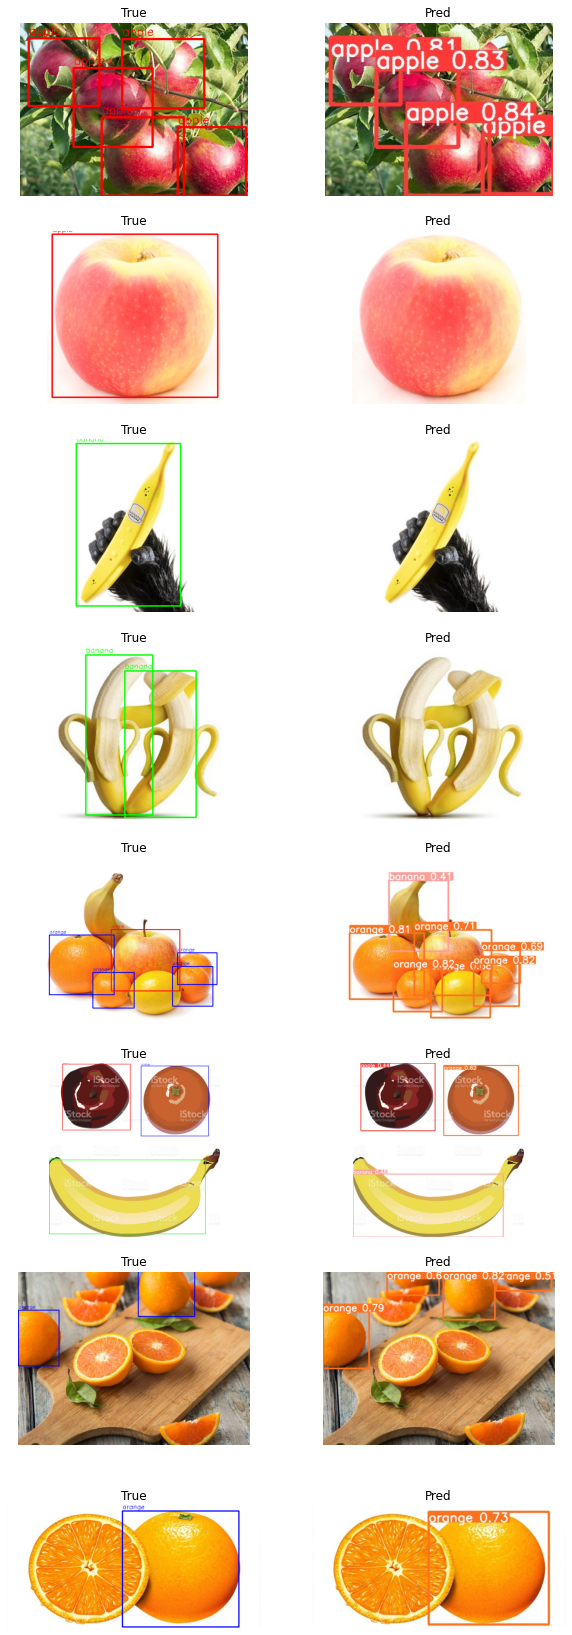

In [68]:
import matplotlib.pyplot as plt
import cv2

fig, ax = plt.subplots(8, 2, figsize = (10, 30))
apple = 0
banana = 0
orange = 0
mixed = 0
row = 0
for i in range(len(gt_imgs)):

  if 'apple' in gt_imgs[i]:
    if apple == 2:
      continue
    apple += 1
  if 'banana' in gt_imgs[i]:
    if banana == 2:
      continue
    banana += 1
  if 'orange' in gt_imgs[i]:
    if orange == 2:
      continue
    orange += 1
  if 'mixed' in gt_imgs[i]:
    if mixed == 2:
      continue
    mixed += 1
  
  if row == 8:
    break

  gt_img = cv2.cvtColor(cv2.imread(gt_imgs[i]), cv2.COLOR_BGR2RGB)
  gt_bbox_img = draw_box(gt_img, gt_labels[i])
  ax[row, 0].imshow(gt_bbox_img)
  ax[row, 0].set_title('True')
  ax[row, 0].axis('off')

  pred_img = cv2.cvtColor(cv2.imread(pred_imgs[i]), cv2.COLOR_BGR2RGB)
  ax[row, 1].imshow(pred_img)
  ax[row, 1].set_title('Pred')
  ax[row, 1].axis('off')

  row += 1